In [143]:
import pandas as pd
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 1000)

## Partie 2 - Modèle de scoring

#### Lecture des données

In [144]:
directory = "/Users/tanguyherserant/Desktop/Cours/M2/ApprentissageSupervise/@projet/projet_app_sup_20/Datasets_projet_MLDS/"
visapremier = pd.read_csv(directory+"VisaPremier.txt", sep = "\t")

In [145]:
visapremier.shape

(1073, 48)

In [146]:
visapremier.head()

,matricul,departem,ptvente,sexe,age,sitfamil,anciente,csp,codeqlt,nbimpaye,mtrejet,nbopguic,moycred3,aveparmo,endette,engagemt,engagemc,engagemm,nbcptvue,moysold3,moycredi,agemvt,nbop,mtfactur,engageml,nbvie,mtvie,nbeparmo,mteparmo,nbeparlo,mteparlo,nblivret,mtlivret,nbeparlt,mteparlt,nbeparte,mteparte,nbbon,mtbon,nbpaiecb,nbcb,nbcbptar,avtscpte,aveparfi,cartevp,sexer,cartevpr,nbjdebit
0,148009,31,1,Shom,51,Fmar,238,Pcad,A,0,0,0,115,701939,4,119216,0,119216,2,35938,114,11,49,206016,0,1,152530,4,701939,2,520145,2,181794,0,0,0,0,0,0,14,2,0,1303700,556967,Coui,0,1,1
1,442153,82,6,Shom,52,Fmar,270,Pcad,A,0,0,4,19579,8920,0,0,0,0,1,132468,4079,11,50,98500,0,0,0,3,19508920,2,8920,0,0,0,0,0,0,1,19500000,5,2,0,19856243,133896,Coui,0,1,0
2,552427,97,1,Shom,58,Fmar,139,Pcad,C,0,0,0,40,3402,0,0,0,0,1,1336,40,14,2,3394,0,0,0,1,3402,0,0,1,3402,0,0,0,0,0,0,0,1,0,122745,0,Coui,0,1,0
3,556005,40,1,Shom,27,Fcel,99,Psan,B,0,0,0,17,76321,0,0,0,0,1,12221,17,11,23,0,0,0,0,3,76321,1,46312,2,30009,0,0,0,0,0,0,14,2,0,83224,0,Coui,0,1,0
4,556686,65,1,Shom,49,Fsep,89,Pemp,A,0,0,0,374,473350,0,209062,37859,171203,1,21187,208,11,49,0,0,1,21423,5,473350,3,399999,2,73351,0,0,0,0,0,0,11,3,1,494773,21423,Coui,0,1,15


Notre variable à prédire est 'cartevpr'. Mais il faudra aussi supprimer cartevp qui donne la même information !

In [147]:
visapremier["cartevpr"].value_counts()

0    714
1    359
Name: cartevpr, dtype: int64

Nous avons environ 33% de label à TRUE. Ce qui est "unbalanced". 
Nous allons utiliser la méthode d'Over-sampling car nous n'avons pas un gros jeu de données. 

Nous allons créer ce nouveau jeu de données pour la base d'apprentissage. 

#### Variables à utiliser

On ne prendra que celles où on a une intuition mais aussi celles qui sont corrélées avec "Possession de la carte Visa Premier".

Nettoyons la base avant de voir les corrélations. 

##### Describe

Describe des variables afin de trouver des aberrations et / ou des valeurs nulles

In [148]:
visapremier.describe(include = 'all')

,matricul,departem,ptvente,sexe,age,sitfamil,anciente,csp,codeqlt,nbimpaye,mtrejet,nbopguic,moycred3,aveparmo,endette,engagemt,engagemc,engagemm,nbcptvue,moysold3,moycredi,agemvt,nbop,mtfactur,engageml,nbvie,mtvie,nbeparmo,mteparmo,nbeparlo,mteparlo,nblivret,mtlivret,nbeparlt,mteparlt,nbeparte,mteparte,nbbon,mtbon,nbpaiecb,nbcb,nbcbptar,avtscpte,aveparfi,cartevp,sexer,cartevpr,nbjdebit
count,1.073000e+03,1073,1073.00000,1073,1073.000000,1073,1073.000000,1073,1073,1073.0,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1.073000e+03,1073.000000,1.073000e+03,1073.000000,1073.000000,1073.000000,1073,1073.000000,1.073000e+03,1.073000e+03,1073.000000,1.073000e+03,1073.000000,1.073000e+03,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1.073000e+03,1073,1073.000000,1073.000000,1.073000e+03,1.073000e+03,1073,1073.000000,1073.000000,1073.000000
unique,NaN,34,NaN,2,NaN,7,NaN,8,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,31,NaN,Shom,NaN,Fmar,NaN,Pcad,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,NaN,NaN,NaN,Cnon,NaN,NaN,NaN
freq,NaN,691,NaN,668,NaN,547,NaN,446,303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278,NaN,NaN,NaN,NaN,714,NaN,NaN,NaN
mean,2.489307e+06,NaN,1.66356,NaN,42.532153,NaN,157.117428,NaN,NaN,0.0,-0.072693,1.505126,47.626281,57249.062442,5.456664,7.731646e+04,4198.657036,2.023004e+04,1.027959,10674.265610,25.906803,NaN,28.999068,2.337927e+04,5.288776e+04,0.239515,3.591471e+04,1.473439,7.544212e+04,0.652377,32183.942218,0.758621,20739.696179,0.058714,4325.424045,0.002796,19.710158,0.000932,1.817335e+04,NaN,1.069897,0.136067,1.468193e+05,5.072736e+04,NaN,0.377446,0.334576,12.084809
std,1.925341e+06,NaN,1.08567,NaN,11.905142,NaN,156.065121,NaN,NaN,0.0,1.578875,2.797290,602.687390,116286.219326,12.329669,2.449631e+05,21851.778213,7.443388e+04,0.499217,24019.413692,133.004659,NaN,26.996182,7.808104e+04,2.215955e+05,0.787877,2.791502e+05,1.284775,6.050985e+05,0.796059,74935.796713,0.787308,60785.281692,0.298161,33123.169657,0.052827,645.639327,0.030528,5.952984e+05,NaN,0.868047,0.379186,7.377687e+05,3.399783e+05,NaN,0.484974,0.472062,23.335589
min,1.133330e+05,NaN,1.00000,NaN,18.000000,NaN,1.000000,NaN,NaN,0.0,-51.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-70050.000000,0.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,0.000000,0.000000,0.000000
25%,8.604360e+05,NaN,1.00000,NaN,33.000000,NaN,45.000000,NaN,NaN,0.0,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,434.000000,2.000000,NaN,6.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,0.000000,0.000000,3.184000e+03,0.000000e+00,NaN,0.000000,0.000000,0.000000
50%,1.948586e+06,NaN,1.00000,NaN,43.000000,NaN,136.000000,NaN,NaN,0.0,0.000000,1.000000,12.000000,6017.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,4371.000000,11.000000,NaN,25.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000,6.017000e+03,0.000000,0.000000,1.000000,127.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,1.000000,0.000000,2.399300e+04,0.000000e+00,NaN,0.000000,0.000000,0.000000
75%,3.901594e+06,NaN,2.00000,NaN,52.000000,NaN,216.000000,NaN,NaN,0.0,0.000000,2.000000,27.000000,57818.000000,6.000000,3.492700e+04,0.000000,0.000000e+00,1.000000,11034.000000,24.000000,NaN,43.000000,3.500000e+03,0.000000e+00,0.000000,0.000000e+00,2.000000,5

Nous avons remarqué quelques incohérences, telles que le nombre de livrets max égal à 4 et le nombre de cartes max égal à 5. Mais sans plus de détails sur le nombre de carte on ne peut rien dire. En effet, ça peut-être dû à des pertes de cartes.

Les colonnes nbop et nbvie ont des valeurs assez élevées en max, mais pas de signe d'aberration.

Nous avons aussi remarqué que nbimpaye était toujours nulle.


In [149]:
pd.unique(visapremier['nbimpaye'])

array([0])

In [150]:
visapremier = visapremier.drop(['nbimpaye'], axis = 1)

##### Gestion des variables catégorielles

Nous avons des variables catégorielles à remettre sous forme de variables quantitatives, nous utiliserons get_dummies de pandas

In [151]:
visaEncode = pd.get_dummies(visapremier[['codeqlt','sexe','sitfamil','csp']])
visaEncode.shape

(1073, 23)

nbpaiecb à l'air d'avoir une valeur "." qui pourrait représenter une valeur nulle, donc nous la mettrons à -1 car nous n'avons pas plus d'information au sujet de cette variable

In [152]:
pd.unique(visapremier['nbpaiecb'])

array(['14', '5', '0', '11', '27', '13', '15', '.', '40', '3', '4', '12',
       '38', '29', '23', '28', '1', '10', '18', '8', '19', '21', '7',
       '16', '6', '20', '25', '30', '42', '2', '17', '69', '26', '9',
       '31', '24', '34', '22', '41', '52', '33', '50', '32', '37', '65',
       '36', '43', '51', '63', '39', '59', '56', '49', '44', '48', '35'],
      dtype=object)

In [153]:
visapremier.loc[visapremier['nbpaiecb']==".",'nbpaiecb'] = '-1'

Regroupement les colonnes

In [154]:
visapremier = visapremier.drop(['codeqlt','sexe','sitfamil','csp'], axis = 1)
visapremier = pd.concat([visapremier,visaEncode], axis = 1)
visapremier.shape # 48 - 5 + 23 = 66 ( base - 5 suppresion de colonnes + nouvelles colonnes)

(1073, 66)

Des "." sont encore présents dans notre base. Cherchons les colonnes et effectuons le même processus que précédemment.

In [155]:
df = visapremier
[(df[col][df[col].eq('.')].index[i], df.columns.get_loc(col)) for col in df.columns for i in range(len(df[col][df[col].eq('.')].index))]


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


[(53, 1),
 (197, 1),
 (296, 1),
 (616, 1),
 (687, 1),
 (715, 1),
 (1016, 1),
 (391, 16),
 (396, 16),
 (475, 16),
 (542, 16),
 (683, 16),
 (695, 16)]

Les colonnes 1 et 16 sont à corriger. 

In [156]:
visapremier.loc[visapremier[visapremier.columns[1]]==".",visapremier.columns[1]] = '-1'
visapremier.loc[visapremier[visapremier.columns[16]]==".",visapremier.columns[16]] = '-1'

##### Correlation entre les variables

In [157]:
corr = visapremier.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

moycred3 est fortement corrélé avec 5 autres variables donc n'apportera rien en plus au modèle. On peut donc la supprimer.

nbbon et mtbon sont aussi fortement corrélées entre elles ainsi qu'avec d'autres variables, il est donc inutile de garder les deux.

engagemt et engageml sont fortement corrélées, il semble que les engagements aux longs termes soit suffisament dominant parmis les engagements (court, moyen et long) pour se confondre avec les engagements totaux. On peut donc supprimer engageml.

aveparfi et mtvie ainsi que mteparmo et moycredi sont fortement corrélées. Cepandant nous n'avons pas forcement d'explications. C'est pourquoi nous decidons de garder les deux variables.

In [158]:
visapremier = visapremier.drop(['moycred3', 'mtbon', 'engageml'], axis = 1)

Gardons seulement les variables qui sont correlées à plus de +/- 0.20 : 

In [159]:
visapremier = visapremier[['nbopguic','aveparmo','engagemt',
                          'engagemm','nbcptvue','moysold3',
                          'nbop','mtfactur','nbcb',
                          'sexe_Sfem','sexe_Shom','csp_Part',
                          'csp_Pcad','csp_Psan','cartevpr']]

Et bien sûr on garde les labels. 

#### Techniques utilisées

Nous allons utiliser les techniques suivantes : 
        - Arbre de decision simple avec méthode CART
        - Random Forest 
        - SVM
        - Gradient Boosting
        - KNN
        - Logistic Regression
        - Naive Bayes
        - LDA / QDA

#### Création du nouveau jeu de données (Random over-sampling)

In [160]:
# Class count
count_class_0, count_class_1 = visapremier['cartevpr'].value_counts()

# divise database par classe
visapremier_class_0 = visapremier[visapremier['cartevpr'] == 0]
visapremier_class_1 = visapremier[visapremier['cartevpr'] == 1]

visapremier_class_1_over = visapremier_class_1.sample(count_class_0, replace=True)
visapremier_over = pd.concat([visapremier_class_0, visapremier_class_1_over], axis=0)

print('Random over-sampling:')
print(visapremier_over['cartevpr'].value_counts())

Random over-sampling:
1    714
0    714
Name: cartevpr, dtype: int64


#### Création des sets entrainement et test

In [161]:
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(visapremier_over.drop(['cartevpr'], axis = 1)),
                                                    visapremier_over['cartevpr'],
                                                    test_size=0.2)
X_train.shape

(1142, 14)

#### Arbre de décision CART

array([[116,  26],
       [ 12, 132]])

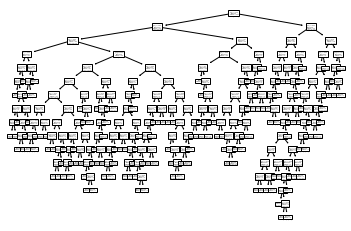

In [162]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

tree.plot_tree(clf) 

pred = clf.predict(X_test)

confusion_matrix(y_test,pred)

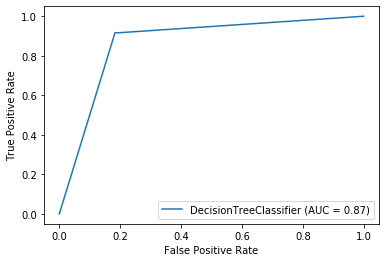

In [163]:
metrics.plot_roc_curve(clf, X_test, y_test)

##### Test des hyperparamètres

###### max_depth

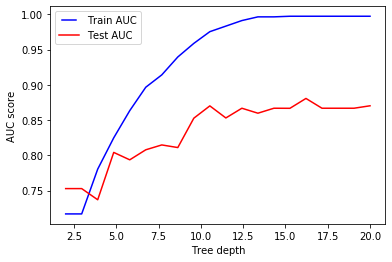

In [164]:
max_depths = np.linspace(2, 20, 20, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")

plt.xlabel("Tree depth")
plt.show()

Nous choisirons 8 en max_depth. 

Car après cette valeur, la valeur de l'AUC est élevée mais ne stagne pas encore et nous voyons que nous overfittons sur le train. 
Ainsi nous avons dû choisir une valeur en dessous de 10 car la ligne bleue est trop élevée après. 
8 est donc le meilleur point sur la ligne rouge.

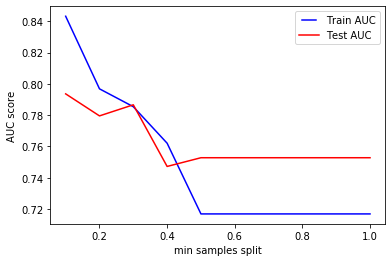

In [165]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = tree.DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=8)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

Avec min sample > 0.5 nous underfittons. Et nous underfittons pour min sample > 0.6

Une valeur de 0.3 semble correcte.

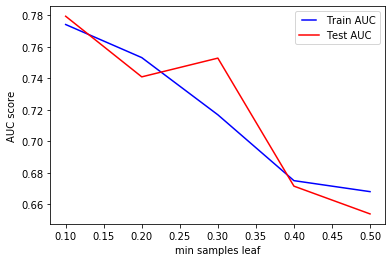

In [166]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=8,min_samples_split=0.3)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples leaf")

plt.show()

Nous overfittons au début puis à la fin nous underfittons.

Il semblerait judicieux de prendre l'entre-deux. Donc 0.3.

##### max_features

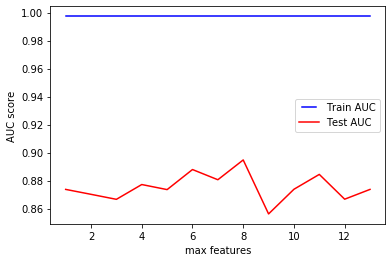

In [167]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = tree.DecisionTreeClassifier(max_features=max_feature)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

Cette information n'apporte rien car trop de variations. 

array([[128,  14],
       [ 57,  87]])

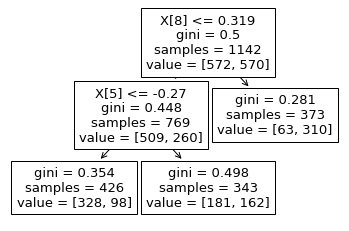

In [168]:
clf = tree.DecisionTreeClassifier(max_depth=8,min_samples_split=0.3, min_samples_leaf=0.3)
clf = clf.fit(X_train, y_train)

tree.plot_tree(clf) 

pred = clf.predict(X_test)

confusion_matrix(y_test,pred)

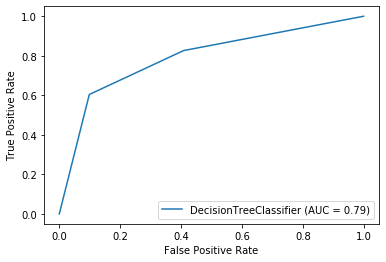

In [169]:
metrics.plot_roc_curve(clf, X_test, y_test)

#### Random Forest

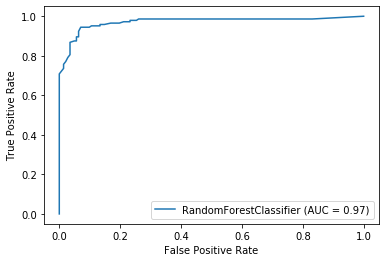

In [170]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

metrics.plot_roc_curve(rf, X_test, y_test)

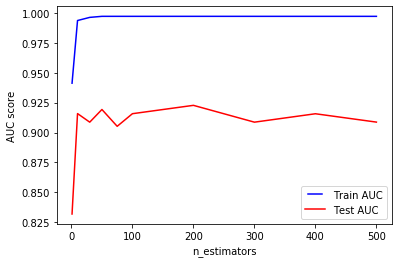

In [171]:
n_estimators = [1, 10, 30, 50, 75, 100, 200, 300, 400, 500]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

Vers 200 estimateurs, on obtiendra le meilleur résultat.

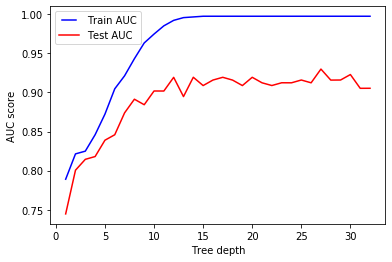

In [172]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators=200)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

On pourrait choisir 10 pour garder de bons résultats en s'éloignant de l'overfitting

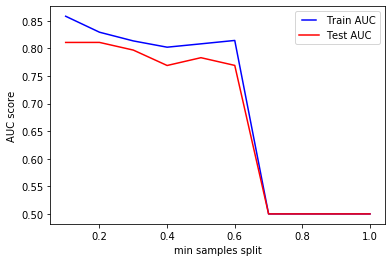

In [173]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split, n_estimators=200, max_depth=10)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

Si min samples split est trop grand, on sous apprend. Donc on va prendre un petit min samples, prenons 0.3.

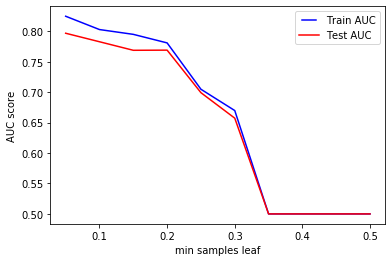

In [174]:
min_samples_leafs = np.linspace(0.05, 0.5, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_estimators=200, max_depth=10)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Même remarque que precedemment, on  prendra arbritrairement 0.1

In [175]:
#metrics.plot_roc_curve(rf, X_test, y_test)

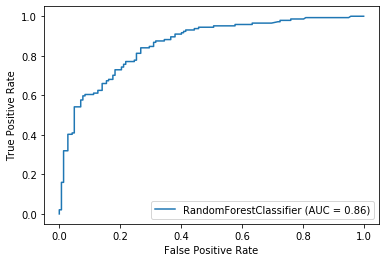

In [176]:
rf = RandomForestClassifier(n_estimators=200,max_depth=10,min_samples_split=0.3, min_samples_leaf=0.1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
metrics.plot_roc_curve(rf, X_test, y_test)

#### SVM

In [177]:
X_train_low = X_train
y_train_low = y_train

##### Visualisation des données

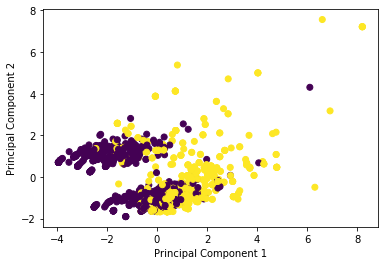

In [178]:
from sklearn.decomposition import PCA

acp = PCA().fit_transform(X_train)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(acp[:, 0], acp[:, 1], c=y_train)

Nous pouvons prédire que le kernel linear ne sera pas performant.

In [179]:
kernels = ['linear', 'rbf', 'poly']


linear   0.3
linear   0.5
linear   0.7


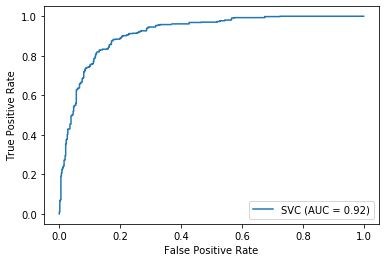

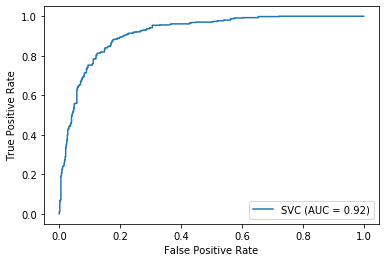

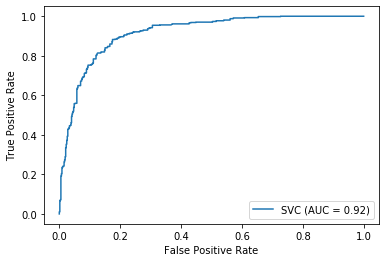

In [180]:
cs = [0.3,0.5,0.7]
for c in cs:
    svc = svm.SVC(kernel='linear', C=c).fit(X_train_low, y_train_low)
    #plotSVC(‘gamma=’ + str(gamma))
    print('linear',' ', c)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    metrics.plot_roc_curve(svc, X_train, y_train)


rbf   0.3   0.1
rbf   0.3   0.5
rbf   0.3   1
rbf   0.5   0.1
rbf   0.5   0.5
rbf   0.5   1
rbf   0.7   0.1
rbf   0.7   0.5
rbf   0.7   1


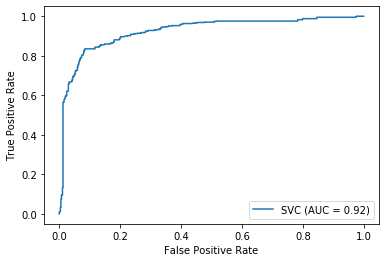

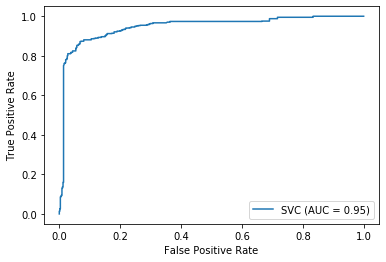

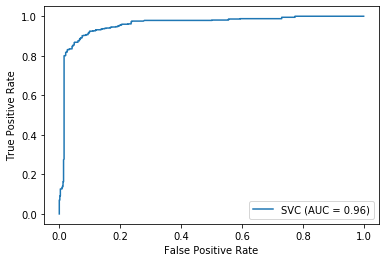

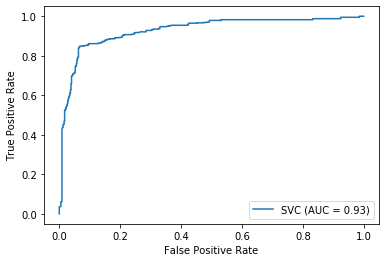

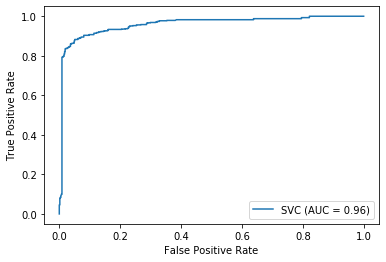

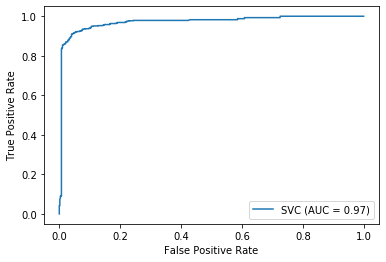

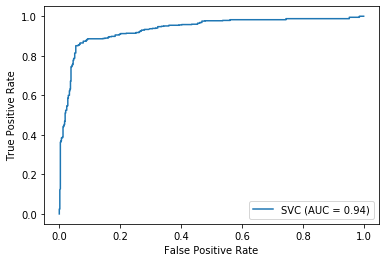

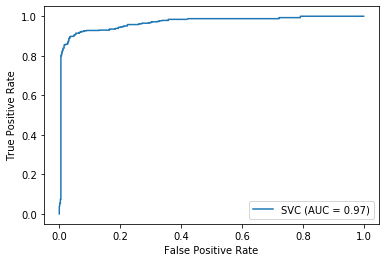

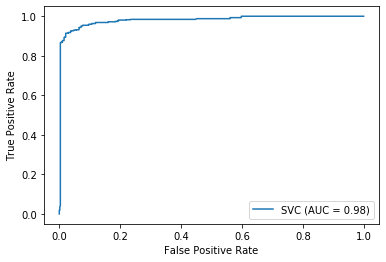

In [181]:
gammas = [0.3,0.5,0.7]
cs = [0.1,0.5, 1]
for gamma in gammas:
        for c in cs:
            svc = svm.SVC(kernel='rbf', gamma=gamma, C=c).fit(X_train_low, y_train_low)
            #plotSVC(‘gamma=’ + str(gamma))
            print('rbf',' ', gamma, ' ', c)
            metrics.plot_roc_curve(svc, X_train, y_train)


poly   0.3   0.1
poly   0.3   0.5
poly   0.3   1
poly   0.5   0.1
poly   0.5   0.5
poly   0.5   1
poly   0.7   0.1
poly   0.7   0.5
poly   0.7   1


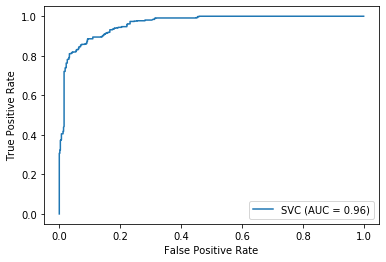

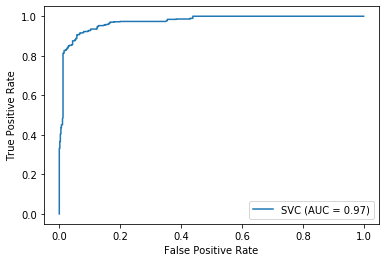

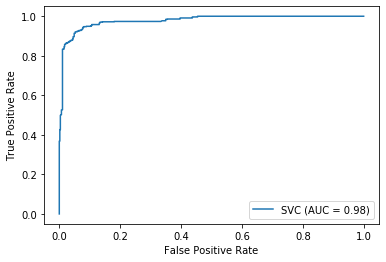

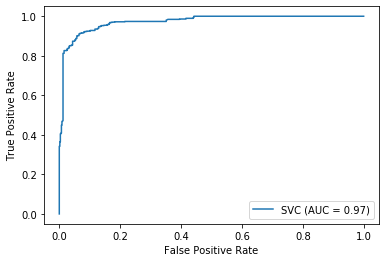

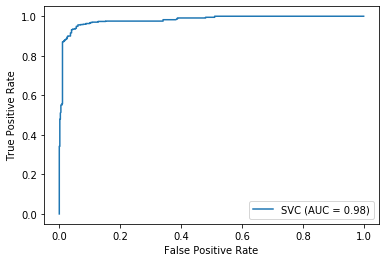

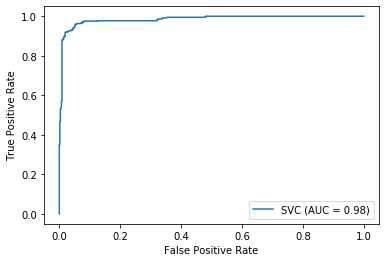

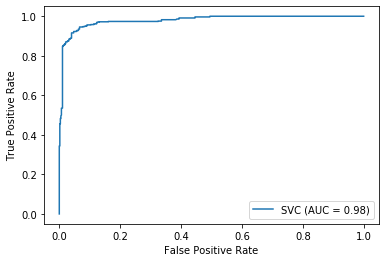

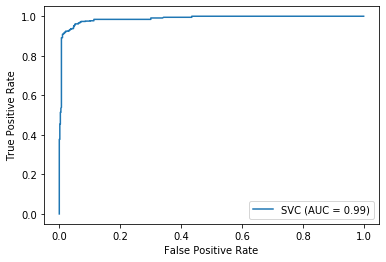

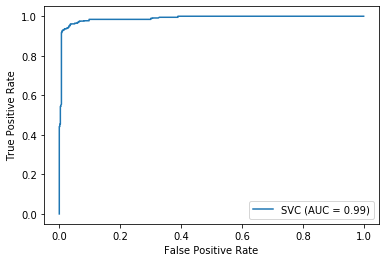

In [182]:
gammas = [0.3,0.5,0.7]
cs = [0.1,0.5, 1]
for gamma in gammas:
        for c in cs:
            svc = svm.SVC(kernel='poly', gamma=gamma, C=c).fit(X_train_low, y_train_low)
            #plotSVC(‘gamma=’ + str(gamma))
            print('poly',' ', gamma, ' ', c)
            metrics.plot_roc_curve(svc, X_train, y_train)


Le meilleur paramètrage de SVM est obtenu avec rbf avec gamma = 0.7 et c = 0.5

#### Gradient Boosting

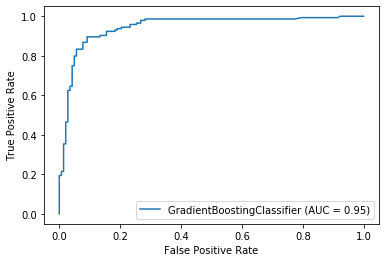

In [183]:
gradBoost = GradientBoostingClassifier()
gradBoost.fit(X_train, y_train)

y_pred = gradBoost.predict(X_test)
metrics.plot_roc_curve(gradBoost, X_test, y_test)

##### Reprenons les mêmes paramètres que pour le random forest

Soit : n_estimators=200,max_depth=10,min_samples_split=0.3, min_samples_leaf=0.1

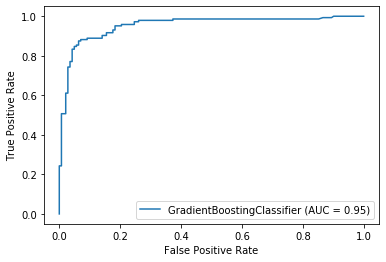

In [184]:
gradBoost = GradientBoostingClassifier(n_estimators=200,max_depth=10,min_samples_split=0.3, min_samples_leaf=0.1)
gradBoost.fit(X_train, y_train)

y_pred = gradBoost.predict(X_test)
metrics.plot_roc_curve(gradBoost, X_test, y_test)

Maintenant regardons le taux d'apprentissage (learning_rate)

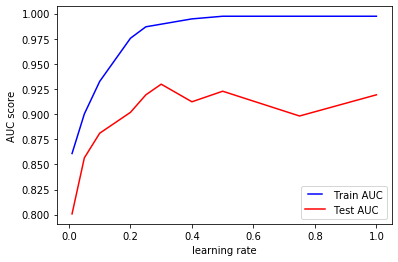

In [185]:
learning_rates = [1,0.75, 0.5,0.4,0.3, 0.25,0.2, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    gradBoost = GradientBoostingClassifier(learning_rate=eta)
    gradBoost.fit(X_train, y_train)
    train_pred = gradBoost.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = gradBoost.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

Il serait préférable de prendre un taux d'apprentissage de 0.3

### KNN

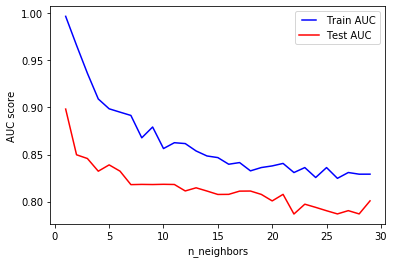

In [186]:
neighbors = list(range(1,30))
train_results = []
test_results = []
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors, train_results, 'b', label='Train AUC')
line2, = plt.plot(neighbors, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

Nous prendrons 7 voisins pour eviter l'overfitting

### Logistic Regression

In [187]:
lr = LogisticRegression().fit(X_train, y_train)

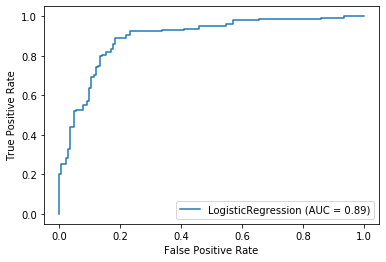

In [188]:
pred = lr.predict(X_test)
metrics.plot_roc_curve(lr, X_test, y_test)

La logistic Regression n'apporte pas d'assez bon résultat

### Naive Bayes

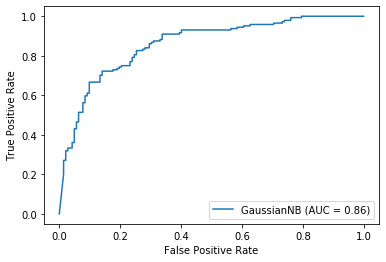

In [189]:
nb = GaussianNB().fit(X_train,y_train)
pred = nb.predict(X_test)
metrics.plot_roc_curve(nb, X_test, y_test)

Même remarque que précédemment 

### LDA

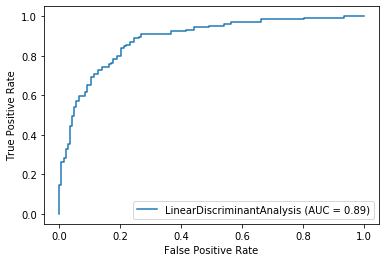

In [190]:
lda = LinearDiscriminantAnalysis().fit(X_train,y_train)
pred = lda.predict(X_test)
metrics.plot_roc_curve(lda, X_test, y_test)

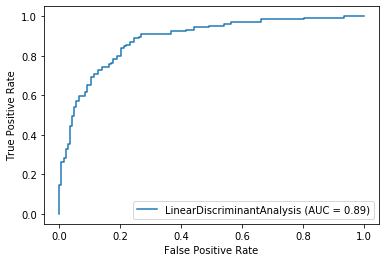

In [191]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = LinearDiscriminantAnalysis().fit(X_train,y_train)
pred = qda.predict(X_test)
metrics.plot_roc_curve(qda, X_test, y_test)

LDA et QDA apporte les mêmes résultats. Nous ne garderons que LDA.

## Modèles avec paramètres : 

### Decision Tree

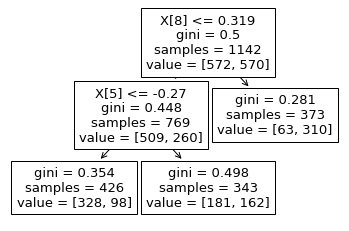

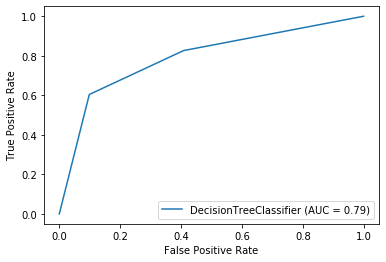

In [192]:
clf = tree.DecisionTreeClassifier(max_depth=8,min_samples_split=0.3, min_samples_leaf=0.3)
clf = clf.fit(X_train, y_train)

tree.plot_tree(clf) 

pred = clf.predict(X_test)

confusion_matrix(y_test,pred)
metrics.plot_roc_curve(clf, X_test, y_test)

### Random Forest

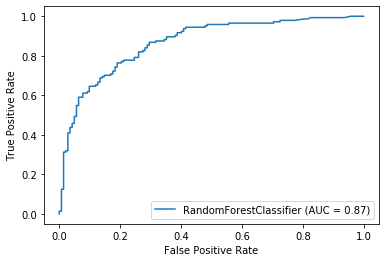

In [193]:
rf = RandomForestClassifier(n_estimators=200,max_depth=10,min_samples_split=0.3, min_samples_leaf=0.1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
metrics.plot_roc_curve(rf, X_test, y_test)

### SVM

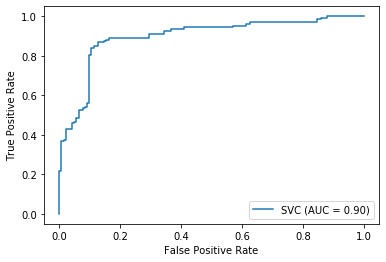

In [194]:
svc = svm.SVC(kernel='poly', gamma=0.7, C=0.5).fit(X_train, y_train)
y_pred = gradBoost.predict(X_test)
metrics.plot_roc_curve(svc, X_test, y_test)

### Gradient Boosting

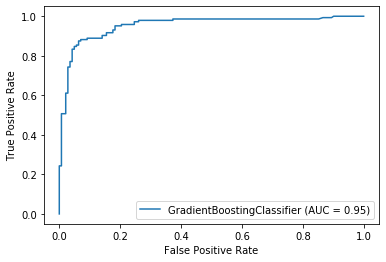

In [195]:
gradBoost = GradientBoostingClassifier(n_estimators=200,max_depth=10,min_samples_split=0.3, min_samples_leaf=0.1)
gradBoost.fit(X_train, y_train)

y_pred = gradBoost.predict(X_test)
metrics.plot_roc_curve(gradBoost, X_test, y_test)

### KNN

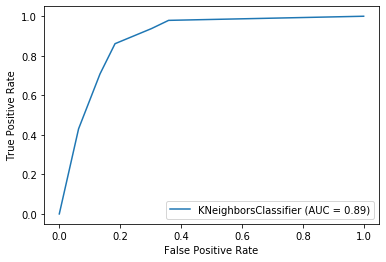

In [196]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
metrics.plot_roc_curve(knn, X_test, y_test)

### LDA

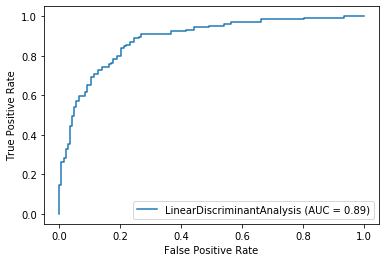

In [197]:
lda = LinearDiscriminantAnalysis().fit(X_train,y_train)
pred = lda.predict(X_test)
metrics.plot_roc_curve(lda, X_test, y_test)

Gradient Boosting nous apporte les meilleurs résultats suivit de LDA et Random Forest. 

### Pour obtenir le score

In [198]:
'''y_pred = np.array([])
for i in rf.predict_proba(X_test):
    if i[0]<0.5:
        y_pred = np.append(y_pred,1)
    else : 
        y_pred = np.append(y_pred,0)
y_pred'''

'y_pred = np.array([])\nfor i in rf.predict_proba(X_test):\n    if i[0]<0.5:\n        y_pred = np.append(y_pred,1)\n    else : \n        y_pred = np.append(y_pred,0)\ny_pred'

## Réduction de dimension

In [199]:
from time import time

def plot_embedding(X, title=None):
    
    plt.figure()
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.scatter(X[:, 0], X[:, 1], c=y_train.values,s=5)
    if title is not None:
        plt.title(title)


In [200]:
X_train.shape

(1142, 14)

### ACP

Computing PCA projection
Done.


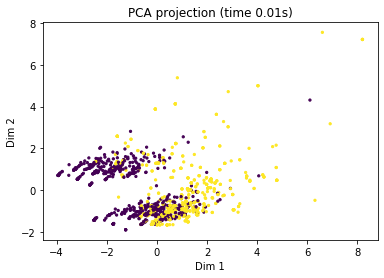

In [201]:
from sklearn.decomposition import PCA

print("Computing PCA projection")
t0 = time()
pca = PCA(n_components=2).fit_transform(X_train)
print("Done.")
plot_embedding(pca,
               "PCA projection (time %.2fs)" %
               (time() - t0))


### ISOMAP

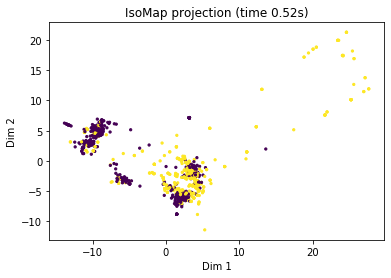

In [202]:
from sklearn.manifold import Isomap

t0 = time()

iso = Isomap(n_components=3, n_neighbors=10).fit_transform(X_train)
plot_embedding(iso,
               "IsoMap projection (time %.2fs)" %
               (time() - t0))


### LLE

Computing LLE embedding
Done. Reconstruction error: 2.37192e-17


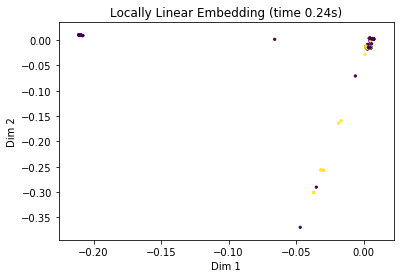

In [203]:
from sklearn.manifold import LocallyLinearEmbedding
print("Computing LLE embedding")
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=20)
t0 = time()
X_lle = lle.fit_transform(X_train)
print("Done. Reconstruction error: %g" % lle.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding (time %.2fs)" %
               (time() - t0))

### TSNE

Computing t-SNE embedding


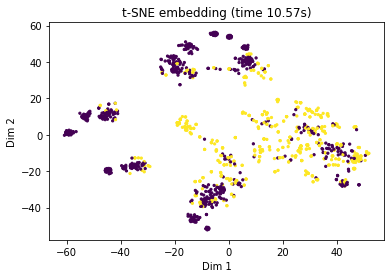

In [204]:
from sklearn.manifold import TSNE
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X_train)

plot_embedding(X_tsne,
               "t-SNE embedding (time %.2fs)" %
               (time() - t0))

### MDS

Computing MDS embedding
Done. Stress: 1101713.649810


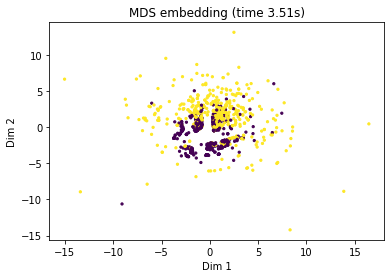

In [205]:
from sklearn.manifold import MDS

print("Computing MDS embedding")
mds = MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = mds.fit_transform(X_train)
print("Done. Stress: %f" % mds.stress_)
plot_embedding(X_mds,
               "MDS embedding (time %.2fs)" %
               (time() - t0))

### UMAP

Computing UMAP embedding


/Applications/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


Done.


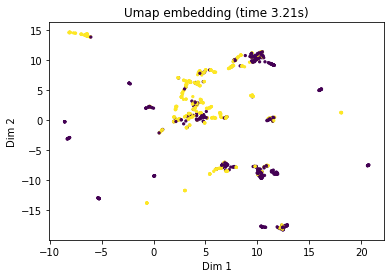

In [206]:
import umap


print("Computing UMAP embedding")
umap = umap.UMAP()
t0 = time()
umap = umap.fit_transform(X_train)
print('Done.')
plot_embedding(umap,
               "Umap embedding (time %.2fs)" %
               (time() - t0))

### Conclusion

Quelque soit l'algorithme, nous n'observons aucun groupe distinct malgrès plusieurs essais de paramètres.